In [1]:
import pandas as pd
import numpy as np
import torch as pt
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#from ml_lib.clusters.root_cluster import RootCluster as Root
from ml_lib.clusters.data_cluster import DataCluster as Data
from ml_lib.clusters.dense_cluster import DenseCluster as Dense
from ml_lib.controllers.controller import Controller as Control

from ml_lib.utils import *

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
dataset = pd.get_dummies(pd.read_csv('data_files/titanic_train.csv', index_col = 'PassengerId'), dummy_na = True, columns = ['Sex', 'Pclass', 'Embarked'])
test_dataset = pd.get_dummies(pd.read_csv('data_files/titanic_test.csv', index_col = 'PassengerId'), dummy_na = True, columns = ['Sex', 'Pclass', 'Embarked'])
feature_cols = [col for col in dataset.columns if col not in ('Name', 'Ticket', 'Cabin', 'Survived', 'Age')]
target_cols = ['Survived']

In [3]:
learner = learners.ADAM
learn_params = {
    'learn_rate': 1e-1,
    'window_rate': 0.1,
    'sq_window_rate': 0.001,
    'scale_features': True,
    'noise_rate': 1e-3,
    'noise_coef': 0.55
}

init = inits.Orthogonal
init_params = {
    'xavier': True
}

activator = activators.ReLU
activator_params = {}

control = Control(valid_split = 'holdout')
control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter = splitters.Holdout, splitter_params = {},
        loss = losses.LogLoss, loss_params = {}
    )
)
control.add_link(
    Dense(
        'reg_cluster_out',
        len(target_cols),
        weight_init = init, weight_init_params = init_params,
        activator = activators.Sigmoid, activator_params = {},
        learner = learner, learner_params = learn_params
    ),
    'data_cluster', 'input', data_cols = feature_cols
)
control.link_clusters('reg_cluster_out', 'data_cluster', data_cols = target_cols)
control.init_clusters()

In [4]:
control.train_model(500)

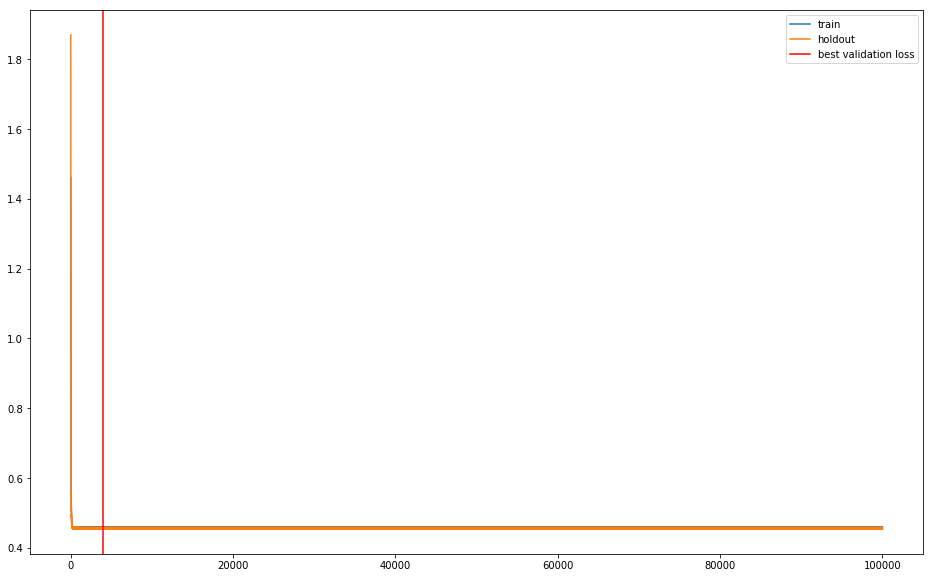

In [5]:
control.plot_losses()

In [6]:
outputs = control.get_outputs(data_override = {'data_cluster': test_dataset[feature_cols]})

In [7]:
control.deinit_clusters()

In [8]:
pd.DataFrame(outputs['reg_cluster_out'].round(), index = test_dataset.index, columns = target_cols).apply(lambda x: x.replace('label_', '')).to_csv('predict.csv')